In [2]:
import sys
sys.path.append(r'C:\Users\festa\OneDrive\Desktop\Thesis\Thesis')
from functions import load_and_process_data, apply_bias_mitigation, evaluate_fairness_metrics, standardize_features, train_classifier_and_find_best_threshold, apply_best_threshold_and_compute_metrics, plot_metrics_dir, plot_metrics_aod, train_classifier_on_transformed_data, extract_fairness_metrics
from functions import evaluate_on_transformed_data_LFR
import numpy as np
from aif360.algorithms.preprocessing import LFR
np.random.seed(1)

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [3]:
train, val, test, privileged_groups, unprivileged_groups = load_and_process_data('adult', use_disparate_impact_remover=False)

In [4]:
# Apply Learning Fair Representations (LFR)
lfr = LFR(unprivileged_groups=unprivileged_groups,
          privileged_groups=privileged_groups,
           k=10, Ax=0.1, Ay=1, Az=1.7, seed=42, 
           verbose=1)
train_transf = lfr.fit_transform(train)
test_transf = lfr.transform(test)

step: 0, loss: 0.764010607050581, L_x: 0.46646400513702657,  L_y: 0.700586430141775,  L_z: 0.009869280232413727
step: 250, loss: 0.663532130543769, L_x: 0.4650692093084988,  L_y: 0.600751278771003,  L_z: 0.00957290049524485
step: 500, loss: 0.6017651863774932, L_x: 0.45961771255804373,  L_y: 0.541473522925093,  L_z: 0.008429348350938715
step: 750, loss: 0.596843750836265, L_x: 0.4551019962339458,  L_y: 0.5385124063511643,  L_z: 0.007541849918650698
step: 1000, loss: 0.5866897187965524, L_x: 0.4383239779347096,  L_y: 0.5359796233430075,  L_z: 0.004045704505925843
step: 1250, loss: 0.5697337935862397, L_x: 0.3941079696863449,  L_y: 0.5192352953917978,  L_z: 0.0065221771916514
step: 1500, loss: 0.5629698130588502, L_x: 0.37965846111757207,  L_y: 0.5127657774413743,  L_z: 0.00719893500336394
step: 1750, loss: 0.5332749406171959, L_x: 0.2612497246301046,  L_y: 0.48474656347236417,  L_z: 0.013178473342247837
step: 2000, loss: 0.5231673762241817, L_x: 0.22900930280129977,  L_y: 0.477997037054

In [5]:
train_before_stat_parity_diff, train_before_disp_impact = evaluate_fairness_metrics(train, unprivileged_groups, privileged_groups, "Train Dataset (Before Transformation)")
test_before_stat_parity_diff, test_before_disp_impact = evaluate_fairness_metrics(test, unprivileged_groups, privileged_groups, "Test Dataset (Before Transformation)")

train_after_stat_parity_diff, train_after_disp_impact = evaluate_fairness_metrics(train_transf, unprivileged_groups, privileged_groups, "Train Dataset (After Transformation)")
test_after_stat_parity_diff, test_after_disp_impact = evaluate_fairness_metrics(test_transf, unprivileged_groups, privileged_groups, "Test Dataset (After Transformation)")

print("Train Dataset (Before Transformation) - Statistical Parity Difference:", train_before_stat_parity_diff)
print("Train Dataset (Before Transformation) - Disparate Impact:", train_before_disp_impact)
print("Test Dataset (Before Transformation) - Statistical Parity Difference:", test_before_stat_parity_diff)
print("Test Dataset (Before Transformation) - Disparate Impact:", test_before_disp_impact)

print("Train Dataset (After Transformation) - Statistical Parity Difference:", train_after_stat_parity_diff)
print("Train Dataset (After Transformation) - Disparate Impact:", train_after_disp_impact)
print("Test Dataset (After Transformation) - Statistical Parity Difference:", test_after_stat_parity_diff)
print("Test Dataset (After Transformation) - Disparate Impact:", test_after_disp_impact)


Train Dataset (Before Transformation) - Statistical Parity Difference: -0.1951
Train Dataset (Before Transformation) - Disparate Impact: 0.3572
Test Dataset (Before Transformation) - Statistical Parity Difference: -0.1893
Test Dataset (Before Transformation) - Disparate Impact: 0.3812
Train Dataset (After Transformation) - Statistical Parity Difference: -0.0081
Train Dataset (After Transformation) - Disparate Impact: 0.8894
Test Dataset (After Transformation) - Statistical Parity Difference: -0.0065
Test Dataset (After Transformation) - Disparate Impact: 0.9121


In [6]:
# Standardize the features (scaling)
train, val, test = standardize_features(train, val, test)

# Choose classifier type
classifier_type = 'random_forest'  # Change to 'random_forest' or 'xgboost'

# Train classifier
classifier, best_threshold, best_balanced_acc = train_classifier_and_find_best_threshold(train, val, classifier_type, unprivileged_groups, privileged_groups)


Best Threshold: 0.21000000000000002
Best Balanced Accuracy: 0.7488044836713941


In [7]:
test_metrics, test_scores = apply_best_threshold_and_compute_metrics(classifier, test, best_threshold, unprivileged_groups, privileged_groups)

Balanced Accuracy (test): 0.7283378706578918
Statistical Parity Difference (test): -0.39403621275497136
Disparate Impact (test): 0.26998821341493756
Average Odds Difference (test): -0.3361414209054696
Equal Opportunity Difference (test): -0.3572719740905325
Theil Index (test): 0.1146766119519563


In [7]:
%matplotlib inline

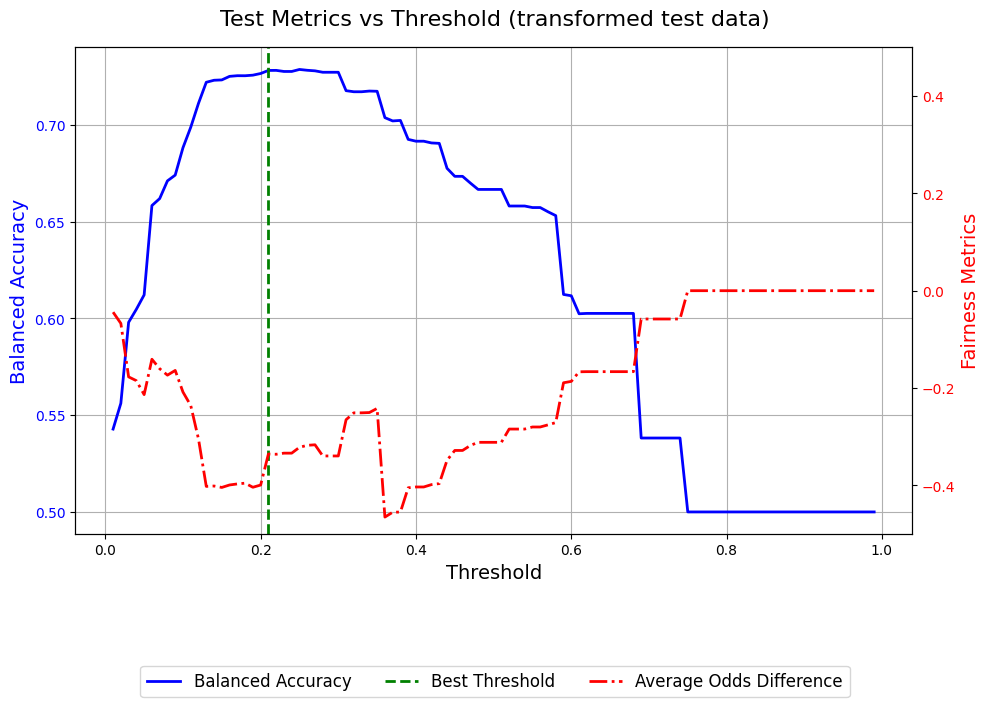

In [11]:
plot_metrics_aod(test, test_scores, best_threshold, unprivileged_groups, privileged_groups)


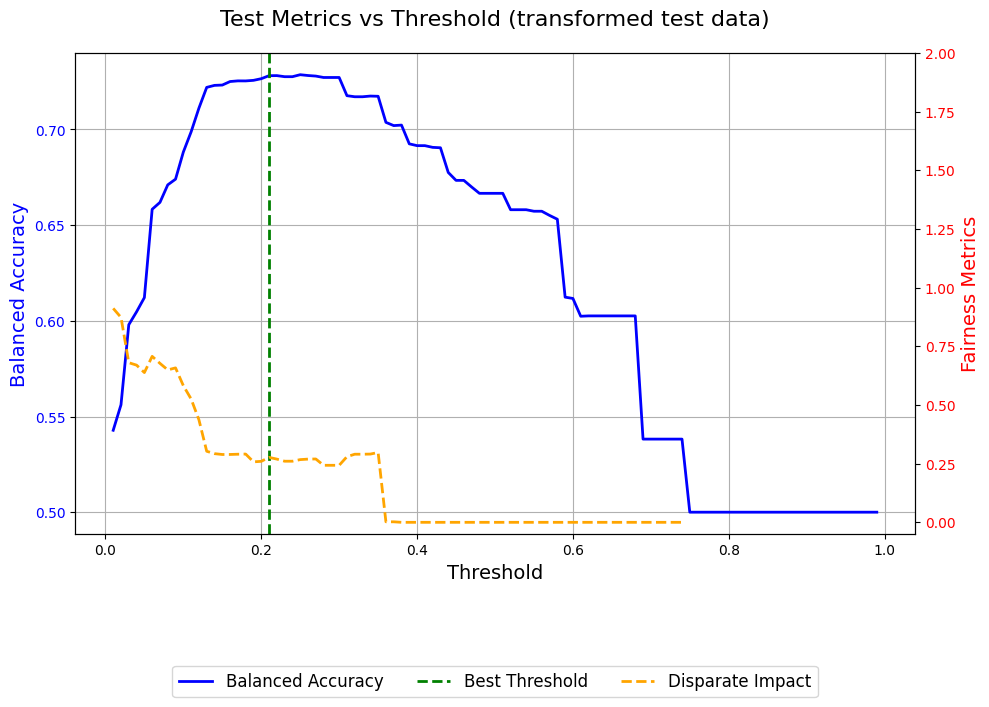

In [12]:
plot_metrics_dir(test, test_scores, best_threshold, unprivileged_groups, privileged_groups)

Unlike other strategies like for example reweighing, where a classifier must be trained to evaluate predictions after adjusting instance weights, LFR generates its own scores as part of its optimization process. These scores are computed to balance reconstruction accuracy, prediction accuracy, and fairness. Since LFR directly provides these fairness-aware scores, there is no need to train a separate classifier on the transformed dataset.

In [8]:
# Standardize the features (scaling)
train_transf, _ , test_transf = standardize_features(train_transf, val, test_transf)
test_transf_scores, test_transf_metrics = evaluate_on_transformed_data_LFR(test, 
    test_transf, best_threshold, unprivileged_groups, privileged_groups)


Balanced Accuracy (test transformed): 0.6829353046388067
Statistical Parity Difference (test transformed): -0.0784316490292985
Disparate Impact (test transformed): 0.863045628203392
Average Odds Difference (test transformed): 0.00136444412598416
Equal Opportunity Difference (test transformed): 0.01717255404082252
Theil Index (test transformed): 0.10330401800867371


In [9]:
%matplotlib inline

c:\Users\festa\AppData\Local\Programs\Python\Python312\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


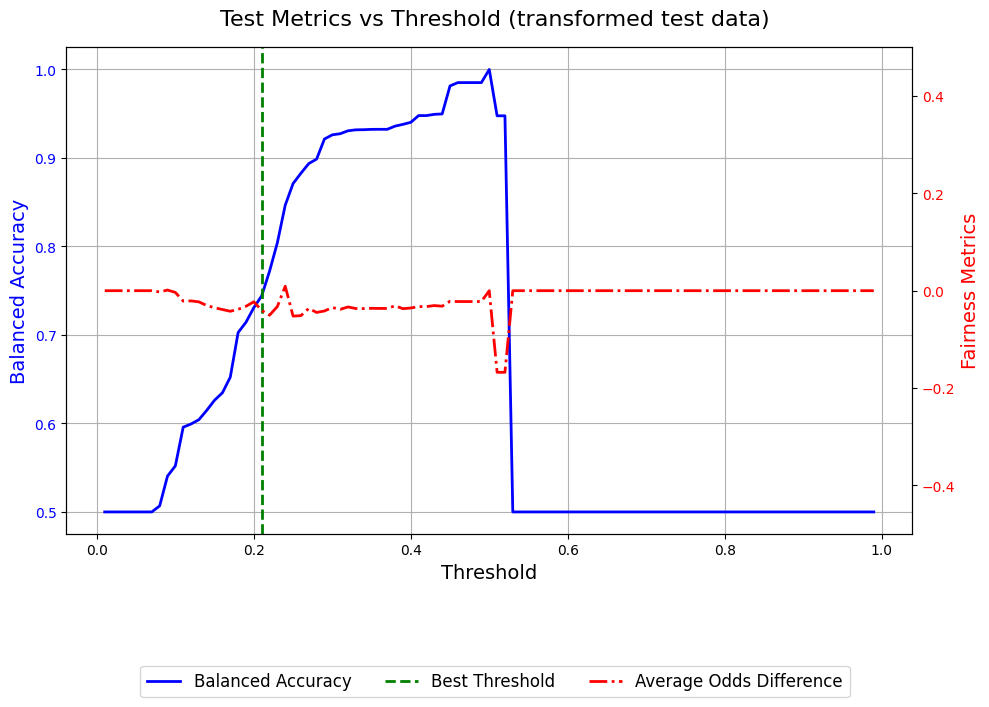

In [9]:
plot_metrics_aod(test_transf, test_transf_scores, best_threshold, unprivileged_groups, privileged_groups)

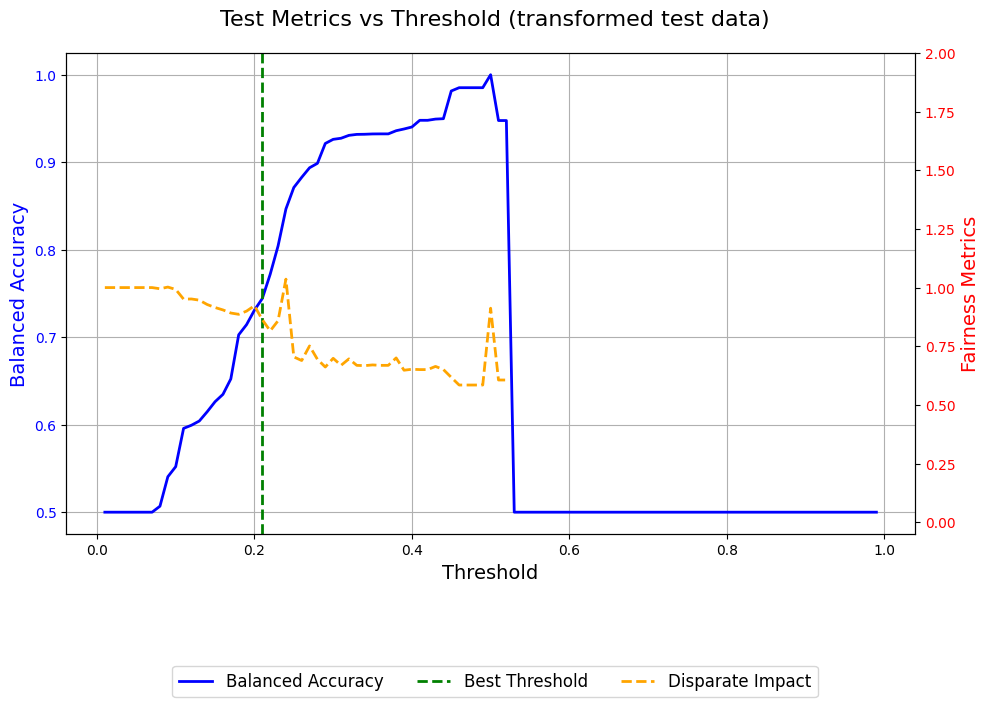

In [10]:
plot_metrics_dir(test_transf, test_transf_scores, best_threshold, unprivileged_groups, privileged_groups)

In [11]:
fairness_metrics, validation_metrics, test_metrics = extract_fairness_metrics(
    train_before_stat_parity_diff, train_after_stat_parity_diff,
    test_before_stat_parity_diff, test_after_stat_parity_diff,
    train_before_disp_impact, train_after_disp_impact,
    test_before_disp_impact, test_after_disp_impact,
    best_threshold, best_balanced_acc,
    test_metrics, test_transf_metrics
)

# Displaying the tables
for table in [fairness_metrics, validation_metrics, test_metrics]:
    display(table.name)
    display(table)


'Fairness Metrics Before and After Transformation'

,Dataset,Stage,Metric,Value
0,Train,Before Transformation,Statistical Parity Difference,-0.1951
1,Train,After Transformation,Statistical Parity Difference,-0.0081
2,Test,Before Transformation,Statistical Parity Difference,-0.1893
3,Test,After Transformation,Statistical Parity Difference,-0.0065
4,Train,Before Transformation,Disparate Impact,0.3572
5,Train,After Transformation,Disparate Impact,0.8894
6,Test,Before Transformation,Disparate Impact,0.3812
7,Test,After Transformation,Disparate Impact,0.9121


'Validation Metrics for Threshold Selection'

,Dataset,Stage,Metric,Value
0,Validation,Best Threshold (Validation),Threshold,0.210000
1,Validation,Best Threshold (Validation),Balanced Accuracy,0.748804


'Test Metrics After Applying Threshold On Original and Transformed'

,Dataset,Stage,Metric,Value
0,Test (Original),After Threshold,Balanced Accuracy,0.728338
1,Test (Transformed),After Threshold,Balanced Accuracy,0.682935
2,Test (Original),After Threshold,Statistical Parity Difference,-0.394036
3,Test (Transformed),After Threshold,Statistical Parity Difference,-0.078432
4,Test (Original),After Threshold,Disparate Impact,0.269988
5,Test (Transformed),After Threshold,Disparate Impact,0.863046
6,Test (Original),After Threshold,Average Odds Difference,-0.336141
7,Test (Transformed),After Threshold,Average Odds Difference,0.001364
8,Test (Original),After Threshold,Equal Opportunity Difference,-0.357272
9,Test (Transformed),After Threshold,Equal Opportunity Difference,0.017173
